In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
mpl.rc('figure', figsize=(16,8))
import matplotlib.pyplot as plt
import os
import glob
import re
import pims
import tifffile
import trackpy as tp

Get list of files in the directory

In [2]:
#files = np.sort(glob.glob(os.path.join(os.getcwd(), 'proc', '*.tif')))
path = '../data/exp_raw/2023-10-23_12B09/'
files = np.sort(glob.glob(os.path.join(path, 'tile*_bp.tif')))
xyfiles = np.sort(glob.glob(os.path.join(path, 'xy*.dat')))
pattern = re.compile(r'\d+.*.tif')
files

array(['../data/exp_raw/2023-10-23_12B09/tile_01_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_02_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_03_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_04_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_05_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_06_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_07_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_08_bp.tif',
       '../data/exp_raw/2023-10-23_12B09/tile_09_bp.tif'], dtype='<U47')

## Preliminary analysis

Use one of the files to find optimal parameters for analysis

In [38]:
j = 1
file = files[j]
fname = pattern.findall(file)[0]
print('Analysing ', fname, '...')
x1, x2, y1, y2 = np.fromfile(xyfiles[j], sep='\n')
print('x: ', x1, x2)
print('y: ', y1, y2)

Analysing  2023-10-23_12B09/tile_02_bp.tif ...
x:  -4328.400000000001 -1013.4000000000005
y:  1191.1000000000001 4512.6


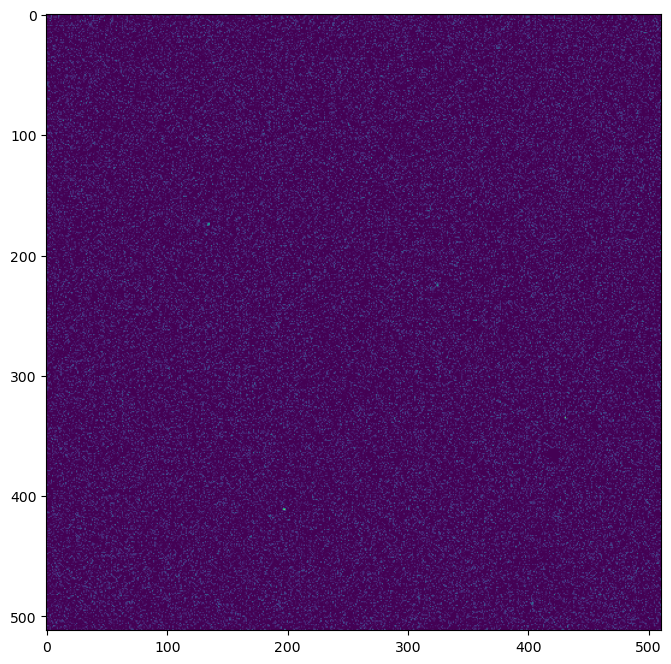

In [39]:
# Read frames
# frames = ND2Reader(file)
frames = tifffile.imread(file)
# Show a sample frame
plt.imshow(frames[-0]);

Locate features

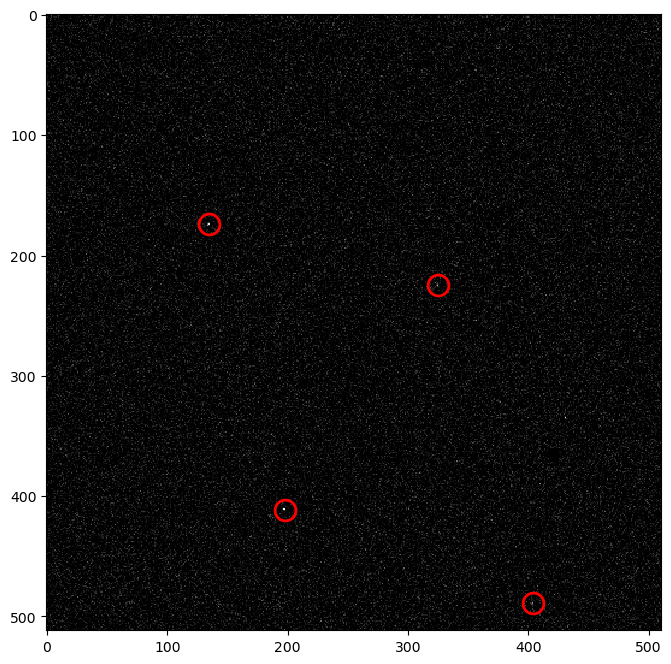

In [40]:
size = 7 # px
minmass = 105
maxsize = 15 # px
f = tp.locate(frames[0], size, minmass=minmass, maxsize=maxsize)
tp.annotate(f, frames[0]);

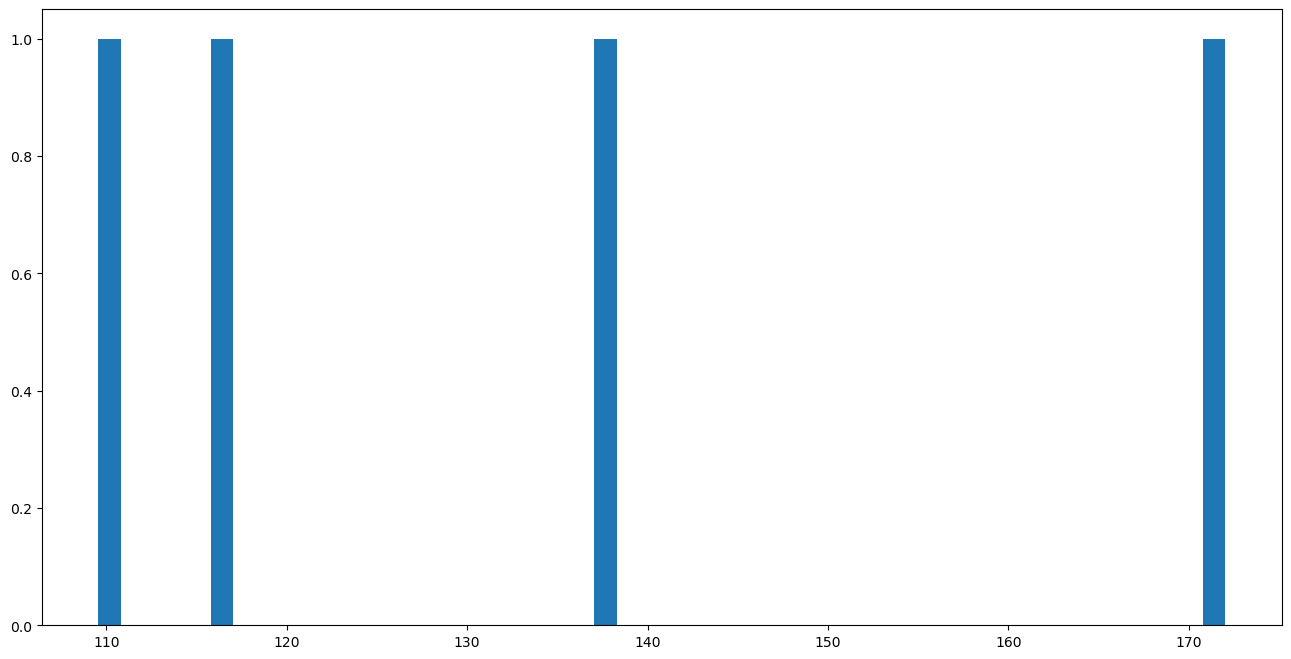

In [41]:
plt.hist(f['mass'], bins=50);

/home/riccardo/miniforge3/envs/tracking/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


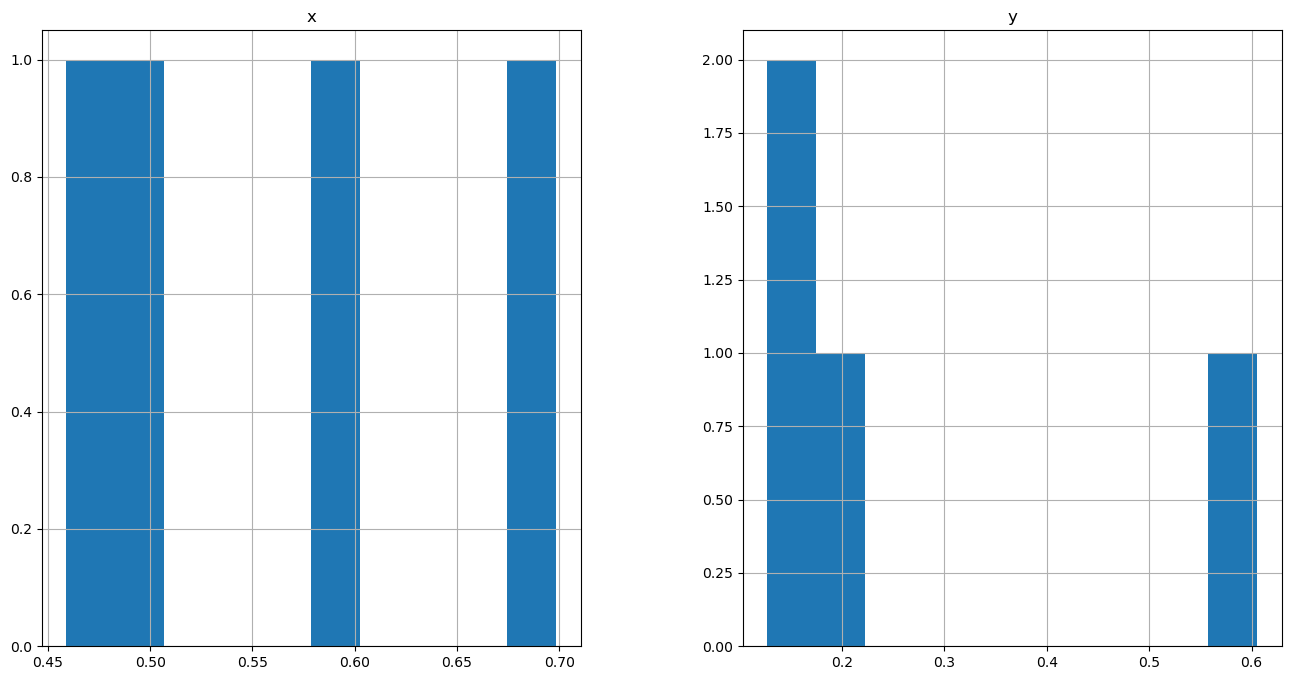

In [42]:
tp.subpx_bias(f);

## Tracking

In [43]:
max_displacement = 60 # px
memory = 3 # frames
f = tp.batch(frames, size, minmass=minmass, maxsize=maxsize)
t = tp.link_df(f, max_displacement, memory=memory)

Frame 894: 4 trajectories present.


In [44]:
min_duration = 250 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

Raw: 283 trajectories
Filtered: 3 trajectories


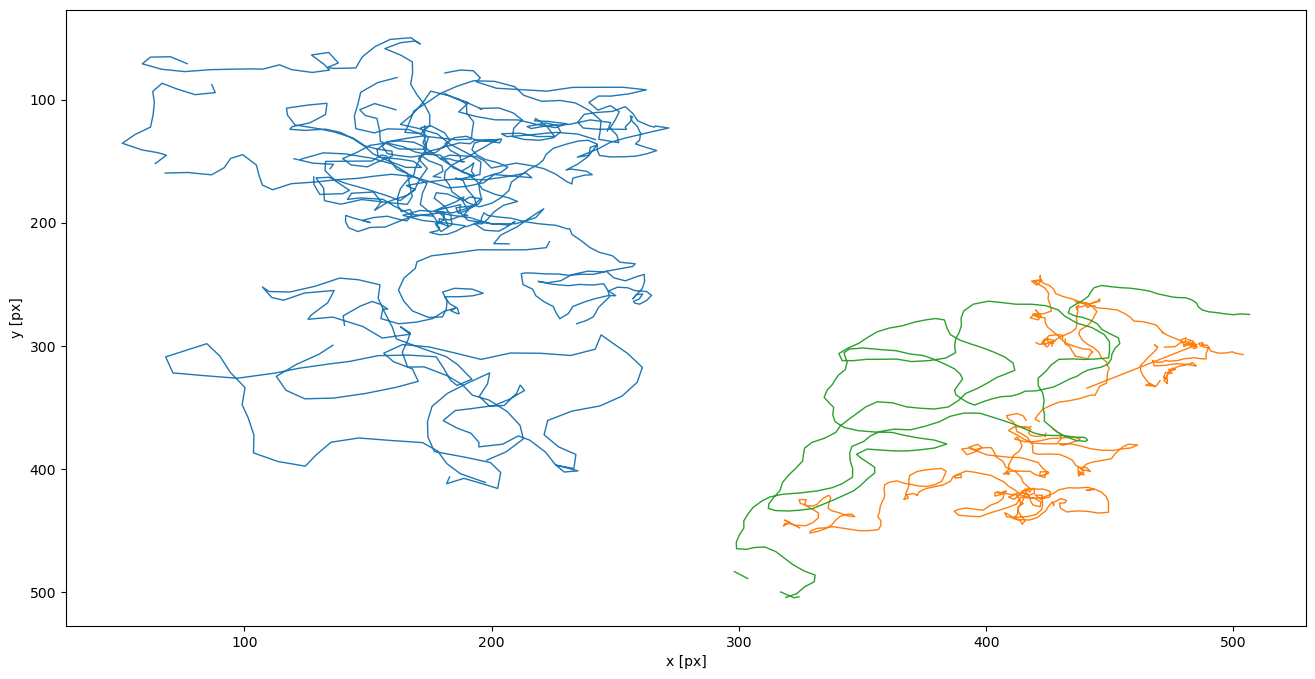

In [45]:
tp.plot_traj(tf);

In [11]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,174.166116,134.499174,137.497563,1.268499,0.290192,23.295042,303.0,0.332125,0
1,224.605675,324.698630,116.134305,1.430380,0.108021,16.931518,364.0,0.247765,0
2,411.126816,197.459049,172.042405,1.269758,0.338524,28.976759,399.0,0.216249,0
3,489.219917,403.602697,109.543513,1.490983,0.103578,13.749756,316.0,0.309656,0
4,167.104641,132.789030,140.088617,1.112264,0.287347,28.372378,270.0,0.271711,1
...,...,...,...,...,...,...,...,...,...
3757,507.827869,229.755269,134.844598,1.229992,0.277227,22.263570,315.0,0.194593,893
3758,282.094012,234.411462,180.633254,1.258327,0.274806,29.543366,413.0,0.192132,894
3759,367.506863,435.320588,118.638712,1.427324,0.093734,15.818495,276.0,0.370408,894
3760,374.574442,350.480769,187.495690,1.397223,0.209879,27.914991,438.0,0.176620,894


## Identify blobs and merge tiles

In [33]:
d = [f for i in range(len(files))] # dummy list of dataframes
for i in range(len(files)):
    x1, x2, y1, y2 = np.fromfile(xyfiles[i], sep='\n')
    frames = tifffile.imread(files[i])
    ny, nx = frames[0].shape
    size = 7 # px
    minmass = 105
    maxsize = 15 # px
    f = tp.batch(frames, size, minmass=minmass, maxsize=maxsize)
    itp_x = lambda x: x1 + x/nx * x2
    itp_y = lambda y: y1 + y/ny * y2
    # inverted dimensions in trackpy
    f['y'] = f['y'].apply(itp_x)
    f['x'] = f['x'].apply(itp_y)
    d[i] = f

df = pd.concat(d)

Frame 894: 2 features


## Track over entire domain

In [34]:
max_displacement = 60*6.5 # μm
memory = 3 # frames
t = tp.link_df(df, max_displacement, memory=memory)
min_duration = 250 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

Frame 894: 13 trajectories present.
Raw: 1652 trajectories
Filtered: 7 trajectories


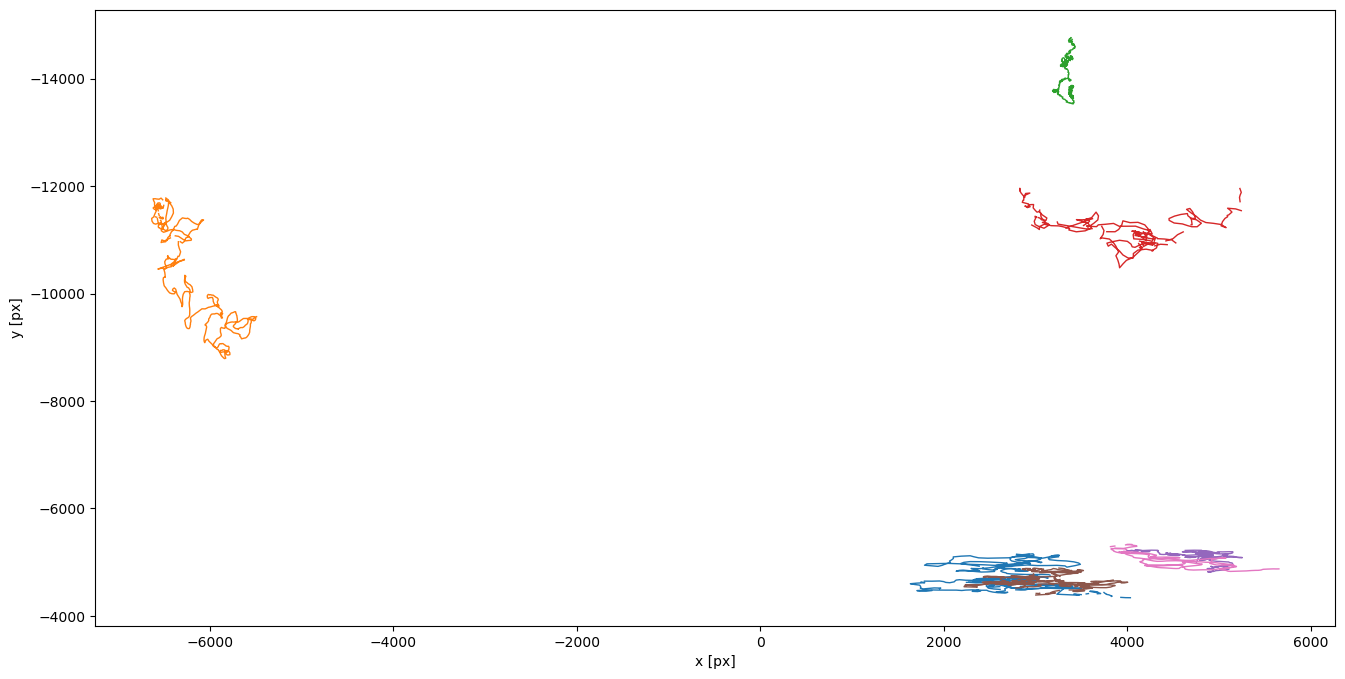

In [35]:
tp.plot_traj(tf);

In [15]:
tf.to_pickle(os.path.join(path, 'tracks_bp.pkl'))